In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sympy
import dill

### Define the regular grid

In [2]:
x0 = 0
xN = 1

y0 = 0
yN = 1

Nx = 20
Ny = 20

X, h_1 = np.linspace(x0, xN, Nx, retstep=True)
Y, h_2 = np.linspace(y0, yN, Ny, retstep=True)

IX, IY = np.meshgrid(X, Y, indexing="xy")
n_points_x = X.shape[0]
n_points_y = Y.shape[0]

### Load precomputed integrals

In [3]:
bilinear_form = np.array(
    dill.load(
        open("../calculations/hermite_cubic_biharmonic_matrix_integral_values", "rb")
    )(h_1, h_2)
)
right_values = np.array(
    dill.load(
        open("../calculations/hermite_cubic_biharmonic_matrix_right_values", "rb")
    )(h_1, h_2)
)

### Assemble the stiffness matrix

In [4]:
x, y = sympy.symbols("x y")

f = sympy.Float(1)
fx = f.diff(x)
fy = f.diff(y)
fxy = f.diff(x, y)

right_part_interp = np.zeros([4, *IX.shape])

right_part_interp[0, ...] = sympy.lambdify([x, y], f)(IX, IY)
right_part_interp[1, ...] = sympy.lambdify([x, y], fx)(IX, IY)
right_part_interp[2, ...] = sympy.lambdify([x, y], fy)(IX, IY)
right_part_interp[3, ...] = sympy.lambdify([x, y], fxy)(IX, IY)

In [5]:
matrix = np.zeros((4 * n_points_y * n_points_x, 4 * n_points_y * n_points_x))
b = np.zeros(4 * n_points_y * n_points_x)

for idx in tqdm(range(n_points_y)):
    for jdx in range(n_points_x):
        if (not (1 <= idx <= n_points_y - 2)) or (not (1 <= jdx <= n_points_x - 2)):
            matrix[
                (4 * idx + 0) * n_points_x + jdx, (4 * idx + 0) * n_points_x + jdx
            ] = 1
            matrix[
                (4 * idx + 1) * n_points_x + jdx, (4 * idx + 1) * n_points_x + jdx
            ] = 1
            matrix[
                (4 * idx + 2) * n_points_x + jdx, (4 * idx + 2) * n_points_x + jdx
            ] = 1
            matrix[
                (4 * idx + 3) * n_points_x + jdx, (4 * idx + 3) * n_points_x + jdx
            ] = 1

            b[4 * idx + 0] = 0
            b[4 * idx + 1] = 0
            b[4 * idx + 2] = 0
            b[4 * idx + 3] = 0

        else:
            for origin_dof in range(4):
                for k in range(3):
                    for l in range(3):
                        for other_dof in range(4):
                            i = (4 * idx + origin_dof) * n_points_x + jdx
                            j = (4 * (idx + k - 1) + other_dof) * n_points_x + (
                                jdx + l - 1
                            )
                            matrix[i, j] = bilinear_form[origin_dof][other_dof][k][l]

                tmp = (
                    right_values[origin_dof]
                    * right_part_interp[:, idx - 1 : idx + 2, jdx - 1 : jdx + 2]
                )

                b[(4 * idx + origin_dof) * n_points_x + jdx] = tmp.sum()

100%|███████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 178.26it/s]


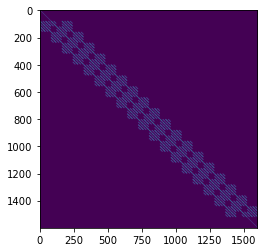

In [6]:
plt.figure()
plt.imshow(matrix != 0)

### Solve the system

In [7]:
c = np.linalg.solve(matrix, b).reshape(4 * n_points_y, n_points_x)

In [8]:
F = c[0::4]
Fx = c[1::4]
Fy = c[2::4]
Fxy = c[3::4]

### Solution plot

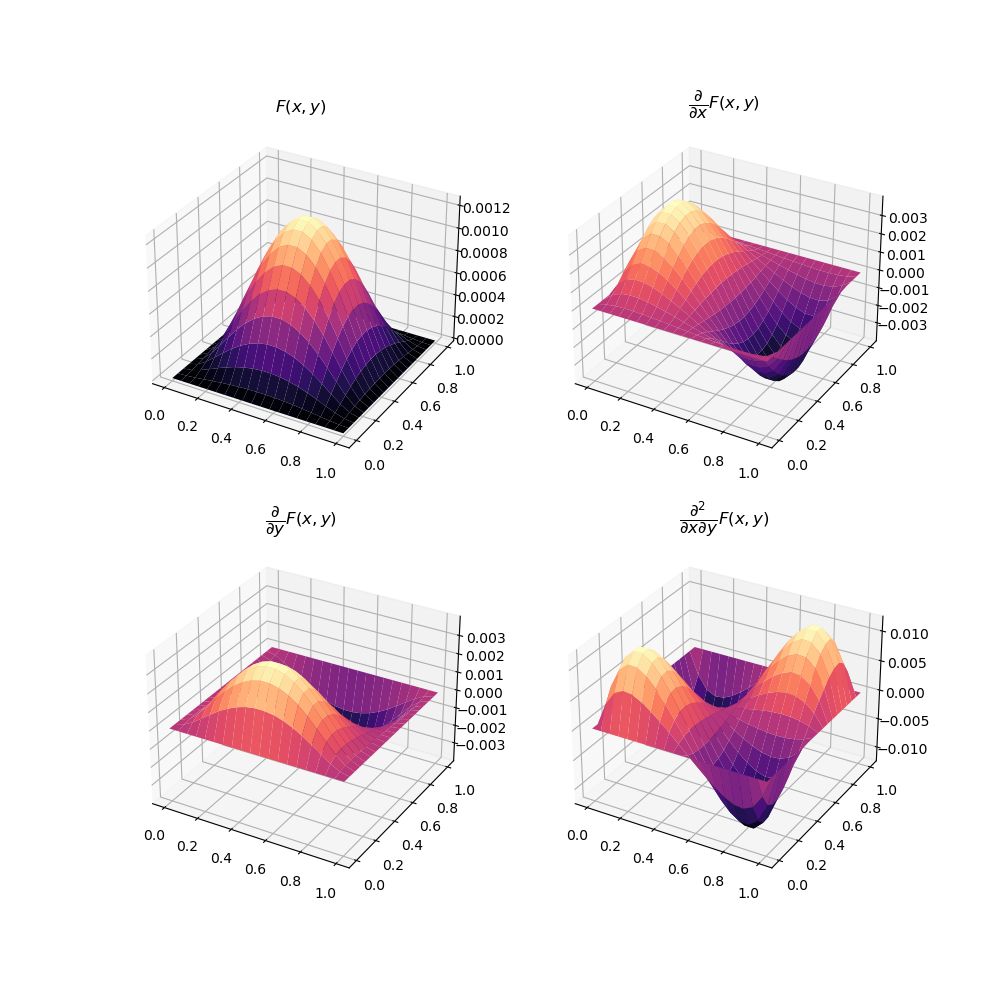

In [9]:
%matplotlib widget
fig, ax = plt.subplots(2, 2, figsize=(10, 10), subplot_kw=dict(projection="3d"))
plot_1 = ax[0, 0].plot_surface(IX, IY, F, cmap="magma")
ax[0, 0].set_title(r"$F\left(x, y\right)$")
plot_2 = ax[0, 1].plot_surface(IX, IY, Fx, cmap="magma")
ax[0, 1].set_title(r"$\dfrac{\partial}{\partial x}F\left(x, y\right)$")
plot_3 = ax[1, 0].plot_surface(IX, IY, Fy, cmap="magma")
ax[1, 0].set_title(r"$\dfrac{\partial}{\partial y}F\left(x, y\right)$")
plot_4 = ax[1, 1].plot_surface(IX, IY, Fxy, cmap="magma")
ax[1, 1].set_title(r"$\dfrac{\partial^{2}}{\partial x\partial y}F\left(x, y\right)$")
plt.show()

### Visualize as combination of basis functions

In [10]:
t, x, y = sympy.symbols("t x y")
phi_0 = sympy.Piecewise(
    ((1 + t) ** 2 * (1 - 2 * t), (t >= -1) & (t <= 0)),
    ((1 - t) ** 2 * (1 + 2 * t), (t >= 0) & (t <= 1)),
    (0, True),
)

phi_1 = sympy.Piecewise(
    ((1 + t) ** 2 * t, (t >= -1) & (t <= 0)),
    ((1 - t) ** 2 * t, (t >= 0) & (t <= 1)),
    (0, True),
)

In [11]:
grid_x = np.linspace(x0, xN, 300)
grid_y = np.linspace(y0, yN, 300)

In [12]:
xx, yy = np.meshgrid(grid_x, grid_y, indexing="ij")
zz = np.zeros_like(xx)

In [13]:
basis_dof_f = sympy.lambdify([x, y], phi_0.subs(t, x) * phi_0.subs(t, y))
basis_dof_fx = sympy.lambdify([x, y], phi_1.subs(t, x) * phi_0.subs(t, y))
basis_dof_fy = sympy.lambdify([x, y], phi_0.subs(t, x) * phi_1.subs(t, y))
basis_dof_fxy = sympy.lambdify([x, y], phi_1.subs(t, x) * phi_1.subs(t, y))

In [14]:
for i in tqdm(range(IY.shape[0])):
    for j in range(IX.shape[1]):
        zz += F[i][j] * basis_dof_f((xx - X[j]) / h_1, (yy - Y[i]) / h_2)
        zz += Fx[i][j] * basis_dof_fx((xx - X[j]) / h_1, (yy - Y[i]) / h_2) * h_1
        zz += Fy[i][j] * basis_dof_fy((xx - X[j]) / h_1, (yy - Y[i]) / h_2) * h_2
        zz += (
            Fxy[i][j] * basis_dof_fxy((xx - X[j]) / h_1, (yy - Y[i]) / h_2) * h_1 * h_2
        )

100%|████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


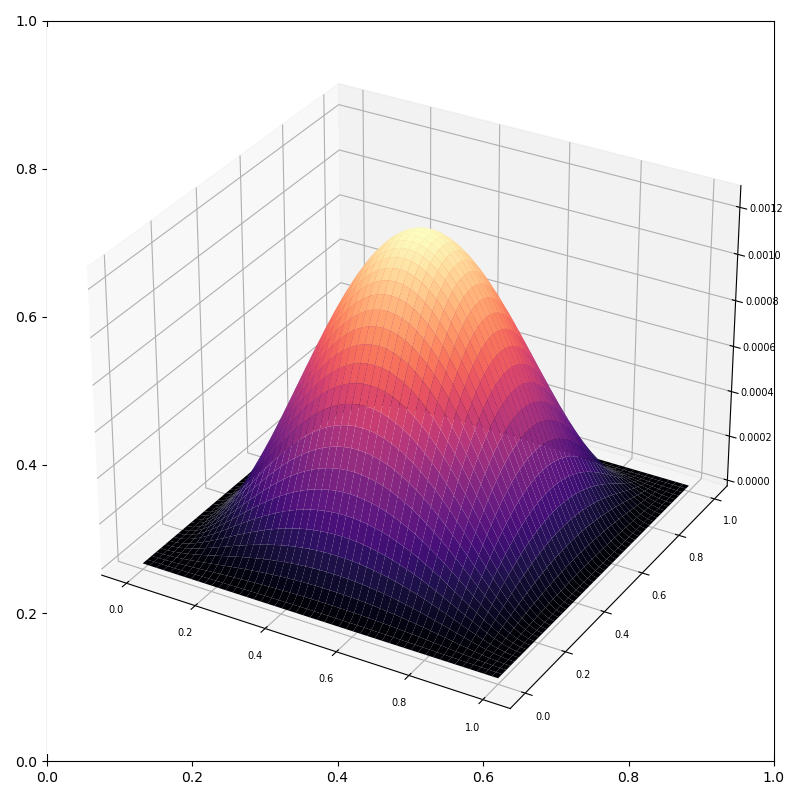

In [15]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(xx, yy, zz, cmap="magma")
ax.tick_params(axis="both", which="major", labelsize=7)
fig.tight_layout()
plt.show()